In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [ ]:
# 1. Load CSV File
df = pd.read_csv('/content/drive/MyDrive/PTTK/RNN/STB/STB Historical Data.csv')
df1 = df.reset_index()['Price']


In [ ]:
# 2. Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [ ]:
# 3. Split Train and Test Data
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# 4. Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [ ]:
# 5. Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# 6. Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
# 7. Fit Model with Training Data
model.fit(X_train, y_train, epochs=200, batch_size=64, verbose=1)


Epoch 1/200
15/15 [==============================] - 1s 19ms/step - loss: 0.1128
Epoch 2/200
15/15 [==============================] - 0s 20ms/step - loss: 0.0052
Epoch 3/200
15/15 [==============================] - 0s 18ms/step - loss: 0.0030
Epoch 4/200
15/15 [==============================] - 0s 18ms/step - loss: 0.0021
Epoch 5/200
15/15 [==============================] - 0s 17ms/step - loss: 0.0019
Epoch 6/200
15/15 [==============================] - 0s 19ms/step - loss: 0.0018
Epoch 7/200
15/15 [==============================] - 0s 19ms/step - loss: 0.0016
Epoch 8/200
15/15 [==============================] - 0s 17ms/step - loss: 0.0016
Epoch 9/200
15/15 [==============================] - 0s 18ms/step - loss: 0.0015
Epoch 10/200
15/15 [==============================] - 0s 19ms/step - loss: 0.0015
Epoch 11/200
15/15 [==============================] - 0s 18ms/step - loss: 0.0015
Epoch 12/200
15/15 [==============================] - 0s 18ms/step - loss: 0.0014
Epoch 13/200
15/15 [=====

In [ ]:
# 8. Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


11/11 [==============================] - 0s 11ms/step


In [ ]:
# 9. Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# 10. Evaluate Model with RMSE
test_rmse = np.sqrt(np.mean((test_predict - scaler.inverse_transform(y_test.reshape(-1, 1))) ** 2))
print('Testing RMSE:', test_rmse)


Testing RMSE: 651.2915852866619


In [ ]:
# 11. Forecast Next 30 Days
last_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

# The rest of your code remains the same
# ...


Testing RMSE: 651.2915852866619
Testing MAE: 504.6820430700646
Testing MAPE: 2.108449556528287


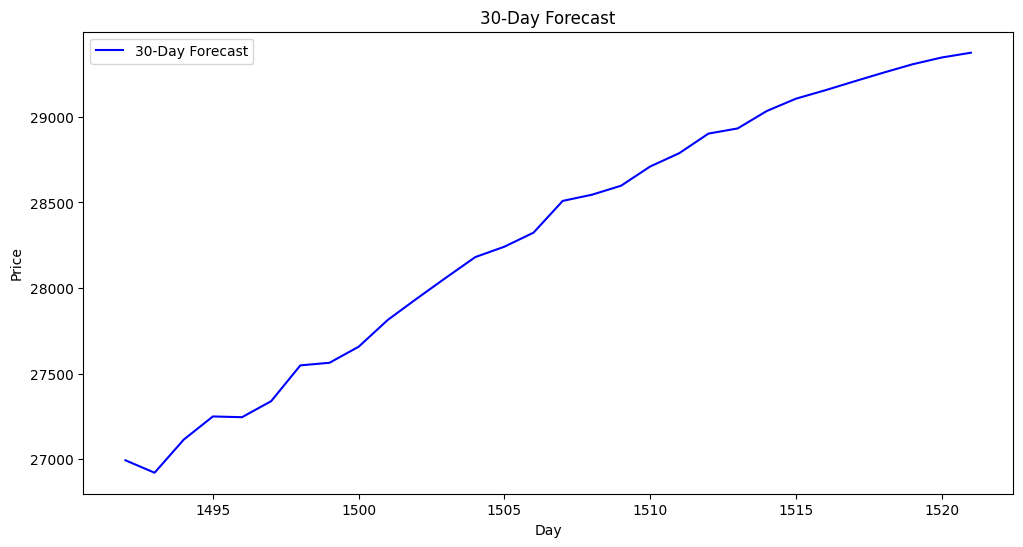

In [ ]:
# Assuming 'lst_output' contains your 30-day forecast
forecast_days = 30
forecast_output = scaler.inverse_transform(lst_output)

# Plotting the 30-day forecast
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(df1), len(df1) + forecast_days), forecast_output, color='blue')
plt.title('30-Day Forecast')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['30-Day Forecast'])
plt.show()


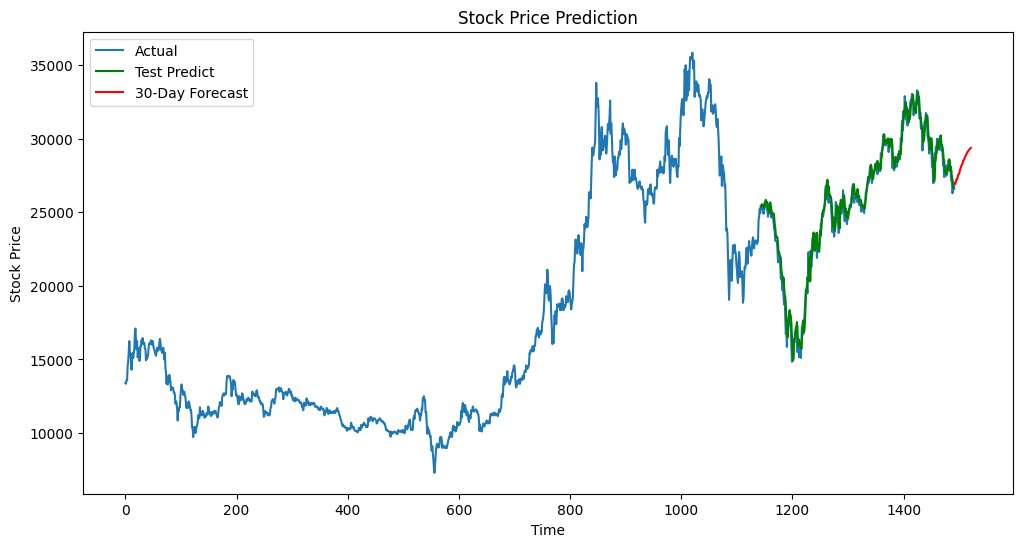

In [ ]:
# Step 12: Plot Results with Train and Test Predictions

plt.figure(figsize=(12, 6))

# Plot entire dataset
plt.plot(scaler.inverse_transform(df1), label='Actual')

# Plot training predictions
train_predict_plot = np.empty_like(df1)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
#plt.plot(train_predict_plot, label='Train Predict', color='orange')

# Plot test predictions
test_predict_plot = np.empty_like(df1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(test_predict_plot, label='Test Predict', color='green')

# Plot 30-day forecast
forecast_days = 30
forecast_output = scaler.inverse_transform(lst_output)
plt.plot(np.arange(len(df1), len(df1) + forecast_days), forecast_output, label='30-Day Forecast', color='red')

# Adding legends and labels
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
